The focus of the project is to predict drug sensitivity (IC50) based on genomic features of cancer cell lines.
It will involve regression tasks to predict the IC50 values or classify cell lines as sensitive or resistant to specific drugs.
Dataset also allows for identification of genomic markers that correlate with drug response. 

Primary targetable variable is LN_IC50 (Natural log of the half-maximal inhibitory concentration): which is the concentration of drug that inhibits cell viability by 50% on a logarithmic scale. Lower values mean higher drug sensitivity.

In [141]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

In [142]:
# Load data
gdsc_data = pd.read_csv('data/GDSC2-dataset.csv')
compound_annotation = pd.read_csv('data/Compounds-annotation.csv')
cellline_details = pd.read_excel('data/Cell_Lines_Details.xlsx', sheet_name = 'Cell line details')

/Users/yongjudan/MLDL_projects/GDSC/gdsc_venv/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [143]:
# Overview data and choose columns for use for gdsc_column
gdsc_column = ['COSMIC_ID', 'CELL_LINE_NAME','TCGA_DESC', 'DRUG_ID','DRUG_NAME', 'PUTATIVE_TARGET',
               'PATHWAY_NAME','MIN_CONC','MAX_CONC', 'LN_IC50', 'AUC', 'RMSE', 'Z_SCORE']

gdsc_data =gdsc_data[gdsc_column]
print(gdsc_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242036 entries, 0 to 242035
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   COSMIC_ID        242036 non-null  int64  
 1   CELL_LINE_NAME   242036 non-null  object 
 2   TCGA_DESC        240969 non-null  object 
 3   DRUG_ID          242036 non-null  int64  
 4   DRUG_NAME        242036 non-null  object 
 5   PUTATIVE_TARGET  214881 non-null  object 
 6   PATHWAY_NAME     242036 non-null  object 
 7   MIN_CONC         242036 non-null  float64
 8   MAX_CONC         242036 non-null  float64
 9   LN_IC50          242036 non-null  float64
 10  AUC              242036 non-null  float64
 11  RMSE             242036 non-null  float64
 12  Z_SCORE          242036 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 24.0+ MB
None


In [144]:
# Overview data and choose columns for use for compound_annotation
annotate_column = ['DRUG_ID', 'DRUG_NAME', 'TARGET', 'TARGET_PATHWAY']

compound_annotation = compound_annotation[annotate_column]
print(compound_annotation.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DRUG_ID         621 non-null    int64 
 1   DRUG_NAME       621 non-null    object
 2   TARGET          579 non-null    object
 3   TARGET_PATHWAY  621 non-null    object
dtypes: int64(1), object(3)
memory usage: 19.5+ KB
None


In [145]:
# Overview data and choose columns for use for cell linedetails
cellline_column = ['COSMIC identifier', 'Sample Name', 'Whole Exome Sequencing (WES)', 'Gene Expression', 'Methylation', 'Drug\nResponse',
                   'GDSC\nTissue descriptor 1', 'GDSC\nTissue\ndescriptor 2', 'Cancer Type\n(matching TCGA label)', 'Microsatellite \ninstability Status (MSI)',
                   'Growth Properties']
cellline_details = cellline_details[cellline_column]

# Rename columns
cellline_details = cellline_details.rename(columns = {'COSMIC identifier' : 'COSMIC_ID', 'Sample Name' : 'CELL_LINE_NAME', 'GDSC\nTissue descriptor 1' : 'GDSC Tissue descriptor 1',
                                                      'GDSC\nTissue\ndescriptor 2' : 'GDSC Tissue descriptor 2', 'Cancer Type\n(matching TCGA label)': 'CANCER_TYPE',
                                                      'Microsatellite \ninstability Status (MSI)':'MSI', 'Drug\nResponse': 'Drug Response'})
print(cellline_details.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   COSMIC_ID                     1001 non-null   float64
 1   CELL_LINE_NAME                1002 non-null   object 
 2   Whole Exome Sequencing (WES)  1002 non-null   object 
 3   Gene Expression               1002 non-null   object 
 4   Methylation                   1002 non-null   object 
 5   Drug Response                 1002 non-null   object 
 6   GDSC Tissue descriptor 1      1001 non-null   object 
 7   GDSC Tissue descriptor 2      1001 non-null   object 
 8   CANCER_TYPE                   826 non-null    object 
 9   MSI                           986 non-null    object 
 10  Growth Properties             999 non-null    object 
dtypes: float64(1), object(10)
memory usage: 86.2+ KB
None


In [146]:
# Merge Tables
merged = pd.merge(gdsc_data, cellline_details, on = ['COSMIC_ID', 'CELL_LINE_NAME'], how = 'left')
final_merge = pd.merge(merged, compound_annotation, on = ['DRUG_ID','DRUG_NAME'], how = 'left')

print(final_merge.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242036 entries, 0 to 242035
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   COSMIC_ID                     242036 non-null  int64  
 1   CELL_LINE_NAME                242036 non-null  object 
 2   TCGA_DESC                     240969 non-null  object 
 3   DRUG_ID                       242036 non-null  int64  
 4   DRUG_NAME                     242036 non-null  object 
 5   PUTATIVE_TARGET               214881 non-null  object 
 6   PATHWAY_NAME                  242036 non-null  object 
 7   MIN_CONC                      242036 non-null  float64
 8   MAX_CONC                      242036 non-null  float64
 9   LN_IC50                       242036 non-null  float64
 10  AUC                           242036 non-null  float64
 11  RMSE                          242036 non-null  float64
 12  Z_SCORE                       242036 non-nul

In [147]:
# Check for duplicates
print(sum(final_merge.duplicated()))

0


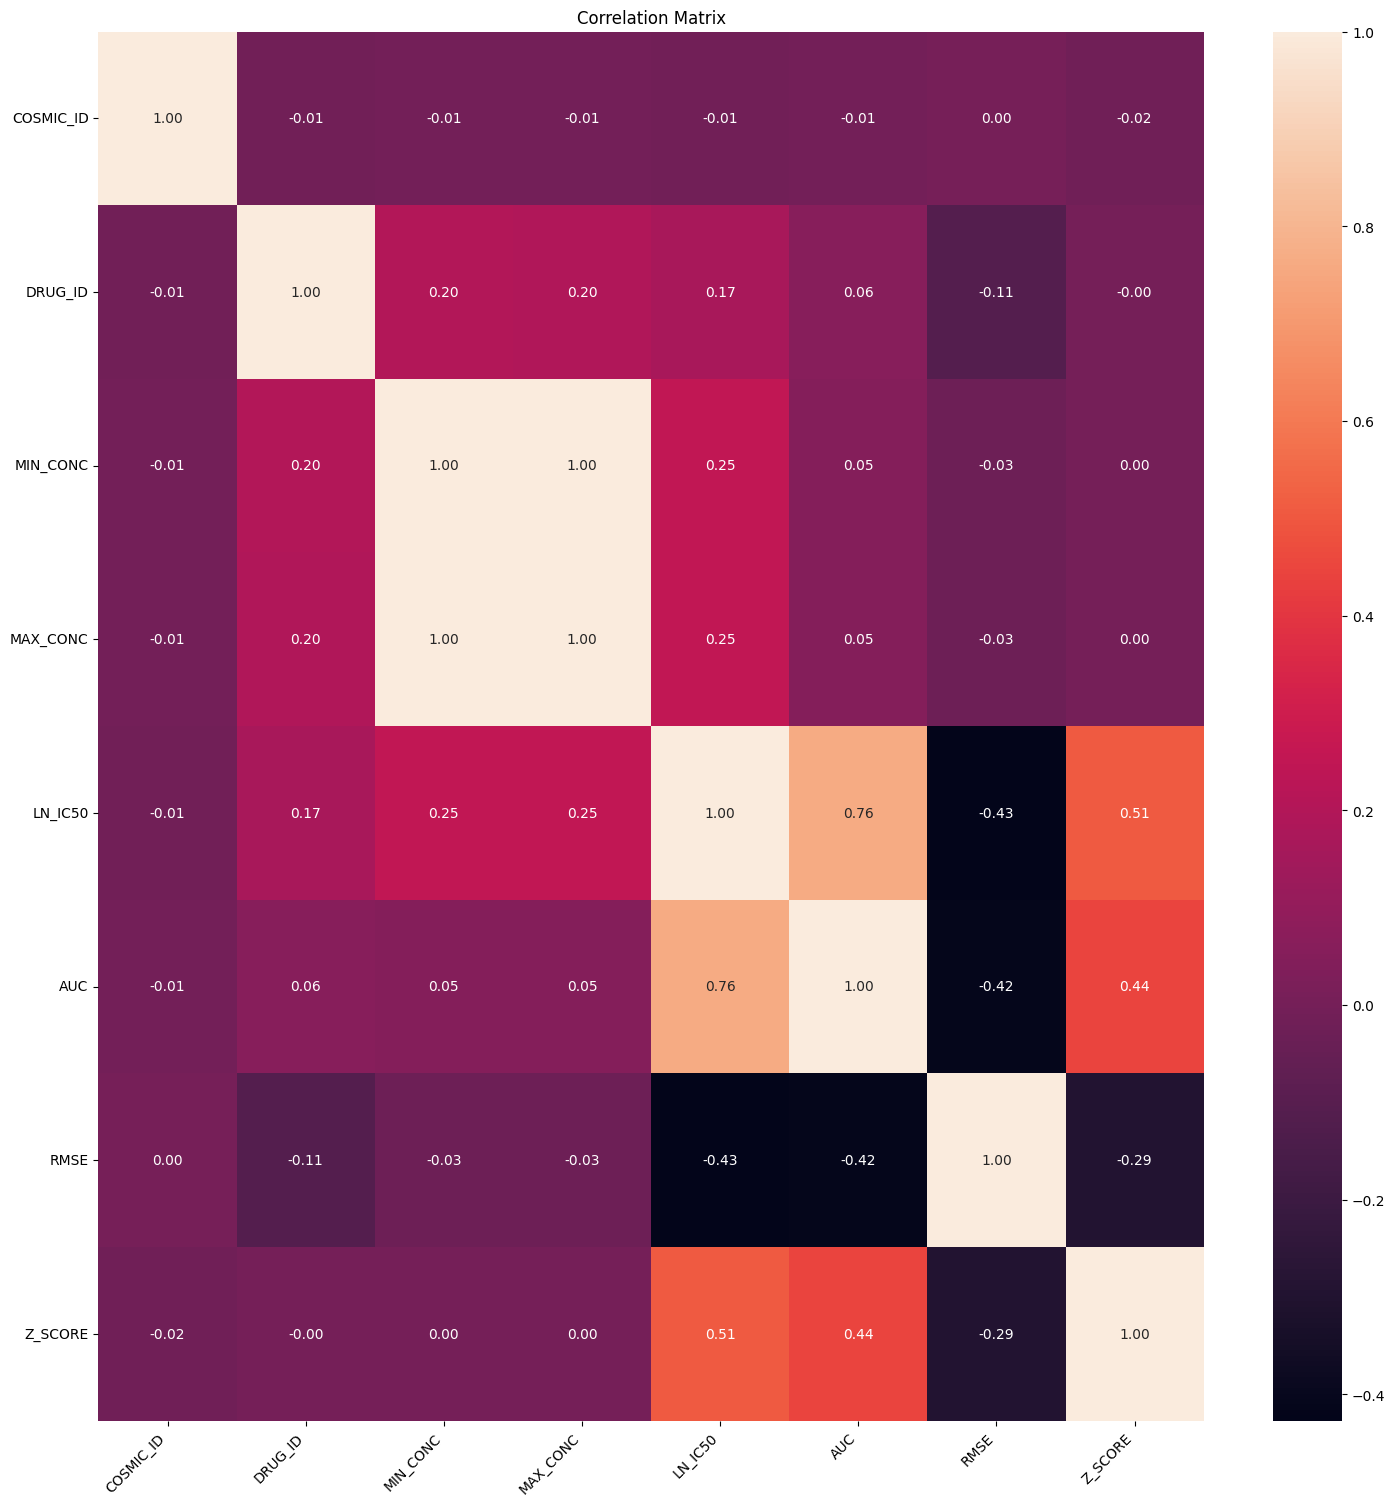

In [148]:
# Check for redundant numeric features
plt.figure(figsize=(15, 15))
sns.heatmap(final_merge.corr(numeric_only=True), annot=True, fmt='.2f')
plt.xticks(rotation=45, ha='right')  # Rotate ticker labels for readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.title(f'Correlation Matrix')
plt.show()
# not much of redundantt numeric features

In [149]:
# Overview of data set
print(final_merge.head(2).T)

                                            0                 1
COSMIC_ID                              683667            684052
CELL_LINE_NAME                         PFSK-1              A673
TCGA_DESC                                  MB      UNCLASSIFIED
DRUG_ID                                  1003              1003
DRUG_NAME                        Camptothecin      Camptothecin
PUTATIVE_TARGET                          TOP1              TOP1
PATHWAY_NAME                  DNA replication   DNA replication
MIN_CONC                               0.0001            0.0001
MAX_CONC                                  0.1               0.1
LN_IC50                             -1.463887         -4.869455
AUC                                   0.93022           0.61497
RMSE                                 0.089052          0.111351
Z_SCORE                              0.433123           -1.4211
Whole Exome Sequencing (WES)                Y                 Y
Gene Expression                         

In [150]:
# Drop cateogorical columns with redundancy
drop_columns = ['TARGET_PATHWAY','PUTATIVE_TARGET']
final_merge.drop(columns=drop_columns, inplace = True)

In [151]:
# Data info
print(final_merge.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242036 entries, 0 to 242035
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   COSMIC_ID                     242036 non-null  int64  
 1   CELL_LINE_NAME                242036 non-null  object 
 2   TCGA_DESC                     240969 non-null  object 
 3   DRUG_ID                       242036 non-null  int64  
 4   DRUG_NAME                     242036 non-null  object 
 5   PATHWAY_NAME                  242036 non-null  object 
 6   MIN_CONC                      242036 non-null  float64
 7   MAX_CONC                      242036 non-null  float64
 8   LN_IC50                       242036 non-null  float64
 9   AUC                           242036 non-null  float64
 10  RMSE                          242036 non-null  float64
 11  Z_SCORE                       242036 non-null  float64
 12  Whole Exome Sequencing (WES)  232670 non-nul

In [152]:
# Save as CSV
final_merge.to_csv('gdsc_dataset.csv', index=False)